# SVM with sigmoid kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)
* coef0 (default 0.0)

Sigmoid kernel function: $(\tanh(\gamma \langle x,x'\rangle + coef0))$

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['11234']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True, length=6416)
    dfs[s] = df
    dfs_test[s] = df_cv
    dfs_cv[s] = df_test

Len of data for  11234 is 6416
Training set length for 11234: 3850
Testing set length for 11234: 1283
Cross-validation set length for 11234: 1283


In [3]:
dfs[stocks[0]].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1283,2013-09-16 14:11:00,"[(950.0, 1000.0), (980.0, 500.0), (1000.0, 842...","[(1115.0, 10340.0), (1116.0, 28731.0), (1117.0...",1114.0,1115.0,1114.5,10340.0,287.0,0.0,-0.945987
1284,2013-09-16 14:13:00,"[(950.0, 1000.0), (980.0, 500.0), (1000.0, 842...","[(1115.0, 12765.0), (1116.0, 25135.0), (1117.0...",1113.0,1115.0,1114.0,12765.0,43988.0,1.0,0.550156
1285,2013-09-16 14:15:00,"[(950.0, 1000.0), (980.0, 500.0), (1000.0, 842...","[(1115.0, 8957.0), (1116.0, 12815.0), (1117.0,...",1114.0,1115.0,1114.5,8957.0,3036.0,0.0,-0.493705
1286,2013-09-16 14:18:00,"[(950.0, 1000.0), (980.0, 500.0), (1000.0, 842...","[(1114.0, 3533.0), (1115.0, 20793.0), (1116.0,...",1113.0,1114.0,1113.5,3533.0,35022.0,1.0,0.816729
1287,2013-09-16 14:19:00,"[(950.0, 1000.0), (980.0, 500.0), (1000.0, 842...","[(1115.0, 13136.0), (1116.0, 20184.0), (1117.0...",1113.0,1115.0,1114.0,13136.0,34319.0,0.0,0.446381


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults for parameters C and gamma.

Next we will choose parameter coef0 for SVM with gamma and C set to the best values we got.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

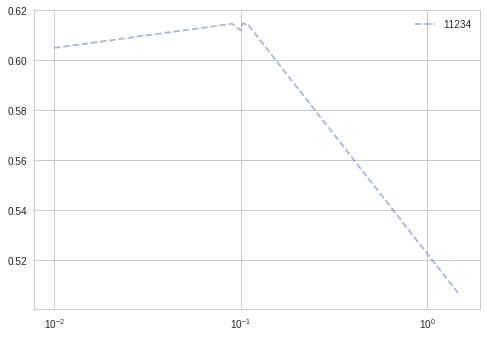

In [5]:
cs = [0.01, 0.09, 0.1, 0.102, 0.105, 0.107, 0.11, 1.5]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, coef0=0)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

Choice of parameter C should be small - less than 0.1

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 11234 the best is 0.105


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 11234 the diff between best and worst 0.10875975631118973


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

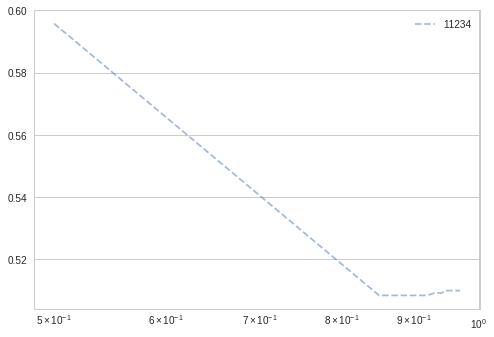

In [8]:
gammas = [0.5, 0.85, 0.87, 0.9, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'sigmoid', gamma=g, coef0=0)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.5)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter.

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 11234 the best is 0.5


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For stocks **10795**, **11618** and **4481** the difference is more than 0.1, so it's definitelly worth to experiment more.

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 11234 the diff between best and worst 0.08745523288631096


In [11]:
df_params = {}

for s in stocks:
    print(s)
    params = []
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': g, 'c': c})
    df_params[s] = pd.DataFrame(params)

11234


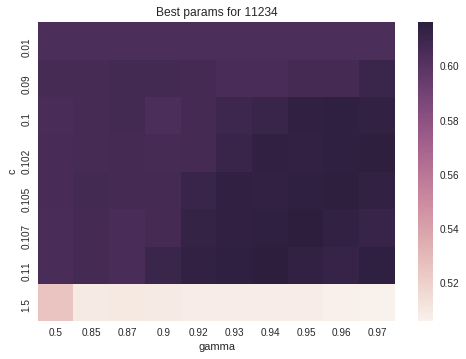

In [12]:
for s in stocks:
    df_g = df_params[s].pivot(index='c', columns='gamma', values='score')
    sns.heatmap(df_g)
    plt.title('Best params for ' + s)
    plt.figure()

In [13]:
for s in stocks:
    print(s, df_params[s].iloc[df_params[s]['score'].idxmax()])

11234 c        0.107000
gamma    0.950000
score    0.616324
Name: 57, dtype: float64


In [14]:
df_params[stocks[0]].sort_values(by='score', ascending=False).head(5)

,c,gamma,score
57,0.107,0.95,0.616324
66,0.110,0.94,0.616324
48,0.105,0.96,0.615571
39,0.102,0.97,0.615571
69,0.110,0.97,0.614667


### Coef0

For sigmoid kernel we use function:
$(\tanh(\gamma \langle x,x'\rangle + r))$, where r is specified by coef0.

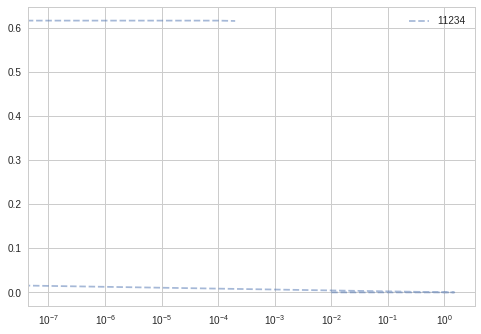

In [15]:
coeffs = [0, 0.0000001, 0.000001, 0.00009, 0.0001, 0.0002]
# 10, 1
df_coefs = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_coef = pd.DataFrame(index=cs)
    df_coef['roc'] = np.zeros(len(df_coef))
    for c in coeffs:
        best_idx = df_params[s]['score'].idxmax()
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=df_params[s].iloc[best_idx]['c'], 
                                     gamma=df_params[s].iloc[best_idx]['gamma'], coef0=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_coef.loc[c] = logit_roc_auc
    plt.plot(df_coef, linestyle='--', label=s, marker='x', alpha=0.5)
    df_coefs[s] = df_coef

plt.legend()

##### Best values of coef0

The value of coef0 should be rather small - less than 0.5.

In [16]:
for s in stocks:
    idx = df_coefs[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 11234 the best is 0.0


##### Influence of coef0

For all stocks choice of coef0 is significant, it can make even 0.5 difference.

In [17]:
for s in stocks:
    err_max = df_coefs[s]['roc'].max()
    err_min = df_coefs[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 11234 the diff between best and worst 0.6163239387274462


#### Best params so far

In [18]:
print(s, '\t', 'C', '\t', 'gamma', '\t', 'coef0')
    
for s in stocks:
    print(s, '\t', df_css[s]['roc'].idxmax(), '\t', df_gammas[s]['roc'].idxmax(), 
          '\t', df_coefs[s]['roc'].idxmax())

11234 	 C 	 gamma 	 coef0
11234 	 0.105 	 0.5 	 0.0


In [19]:
df_params_coef = {}
for s in stocks:
    print(s)
    params = []
    for idx, row in df_params[s].iterrows():
        for coef in coeffs:
            reg_svm = svm_classification(dfs[s], 'sigmoid', C=row['c'], 
                                         gamma=row['gamma'], coef0=coef)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': row['gamma'], 'c': row['c'], 'coef0': coef})
    df_params_coef[s] = pd.DataFrame(params)
    print(df_params_coef[s]['score'].idxmax())

    

11234
342


In [20]:
df_params_coef[stocks[0]].sort_values(by='score', 
                                      ascending=False)[df_params_coef[
    stocks[0]]['score']> 0.6]

,c,coef0,gamma,score
396,0.110,0.000000e+00,0.94,0.616324
345,0.107,9.000000e-05,0.95,0.616324
344,0.107,1.000000e-06,0.95,0.616324
343,0.107,1.000000e-07,0.95,0.616324
342,0.107,0.000000e+00,0.95,0.616324
397,0.110,1.000000e-07,0.94,0.616324
346,0.107,1.000000e-04,0.95,0.616324
400,0.110,1.000000e-04,0.94,0.616324
399,0.110,9.000000e-05,0.94,0.616324
398,0.110,1.000000e-06,0.94,0.616324


# Results

We compare reults of SVMs with the best choices of parameter against the logistic regression and SVM with defaults.

We will use naive approach - for each stock we will just pick the best values we found in the previous section.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set. The **coef0** parameter "depend" of the choice of the rest of parameters.

For 3 stocks the results are quite good, the rest is very bad.

In [21]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['sigmoid-tunned'] = np.zeros(len(stocks))
df_results['c-tunned'] = np.zeros(len(stocks))
df_results['coef-tunned'] = np.zeros(len(stocks))
df_results['gamma-tunned'] = np.zeros(len(stocks))

0.107 0.95 0.0


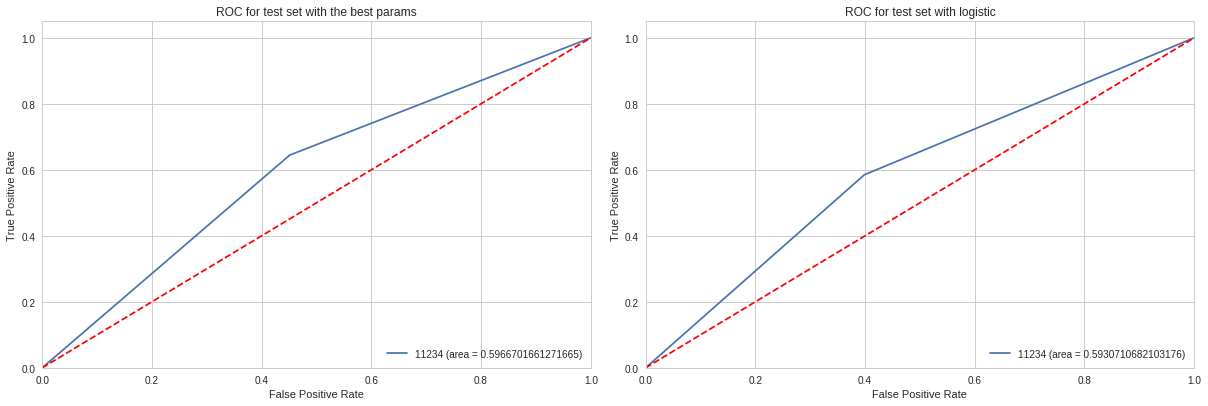

In [22]:
plt.subplot(121)

for s in stocks:
    best_idx = df_params_coef[s]['score'].idxmax()
    c = df_params_coef[s].iloc[best_idx]['c']
    gamma = df_params_coef[s].iloc[best_idx]['gamma']
    coef0 = df_params_coef[s].iloc[best_idx]['coef0']
    print(c, gamma, coef0)
    df_results['c-tunned'][s] = c
    df_results['coef-tunned'][s] = coef0
    df_results['gamma-tunned'][s] = gamma
    
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=c, gamma=gamma, coef0=coef0)
    roc_score = lob.plot_roc(dfs_test[s], reg_svm, stock=s, title='ROC for test set with the best params')
    df_results['sigmoid-tunned'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(dfs_test[s], reg_log, stock=s, title='ROC for test set with logistic')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [23]:
df_results

,logistic,sigmoid-tunned,c-tunned,coef-tunned,gamma-tunned
11234,0.593071,0.59667,0.107,0.0,0.95


In [24]:
for s in stocks:
    ddd = df_params_coef[s]
    print(s)
    print(ddd.iloc[ddd['score'].idxmax()])
    print()

11234
c        0.107000
coef0    0.000000
gamma    0.950000
score    0.616324
Name: 342, dtype: float64



In [25]:
s = stocks[0]
reg_svm = svm_classification(dfs[s], 'sigmoid', C=0.005, 
                             gamma=10, coef0=1)
prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
score = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
score

0.59368347379778941

# Conclusions


We didn't use valid grid approach for choosing the best parameters, so there is possibility that these parameters could be improved. For one stock **2051** we have significant improvement (even when we consider other results). For stock **11618** we have small improvement.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>